## Correct the spectra by redshift and normalize it

In this notebook I'll make plots of the spectra at restframe wavelengths, and later normalize them.

- The wavelength for normalization will be: ??
- The redshift range is: 2.27 to 9.29
- The restframe wavelength range for the whole sample is: 0.048 $\mu m$  to  1.68 $\mu m$
- The overlap range is between 0.15 to 0.53 $\mu m$

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
## importing libraries
from functions.plot import make_spectrum_panel
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import pandas as pd

In [14]:
hdul = fits.open("deGraaff2025_lrds_withdups_blackbody_eline_fits.fits")
hdul.info()
data = hdul[1].data

files = data["file"]
redshifts = data["zspec"]

#transforming into numpy arrays
files = np.array(files)
redshifts = np.array(redshifts)

print(redshifts.min(), redshifts.max())

spec_info_all = list(zip(files, redshifts))

#removing info from the spectra of program MoM (GO5224) since we don't have its spectra
spec_info_clear = spec_info_all[:59] + spec_info_all[72:]
print(len(spec_info_clear))


Filename: deGraaff2025_lrds_withdups_blackbody_eline_fits.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PHOT          1 BinTableHDU     94   134R x 32C   [K, K, 24A, 57A, D, D, D, D, D, K, 196A, L, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D]   
2.2734878 9.294025001594942
121


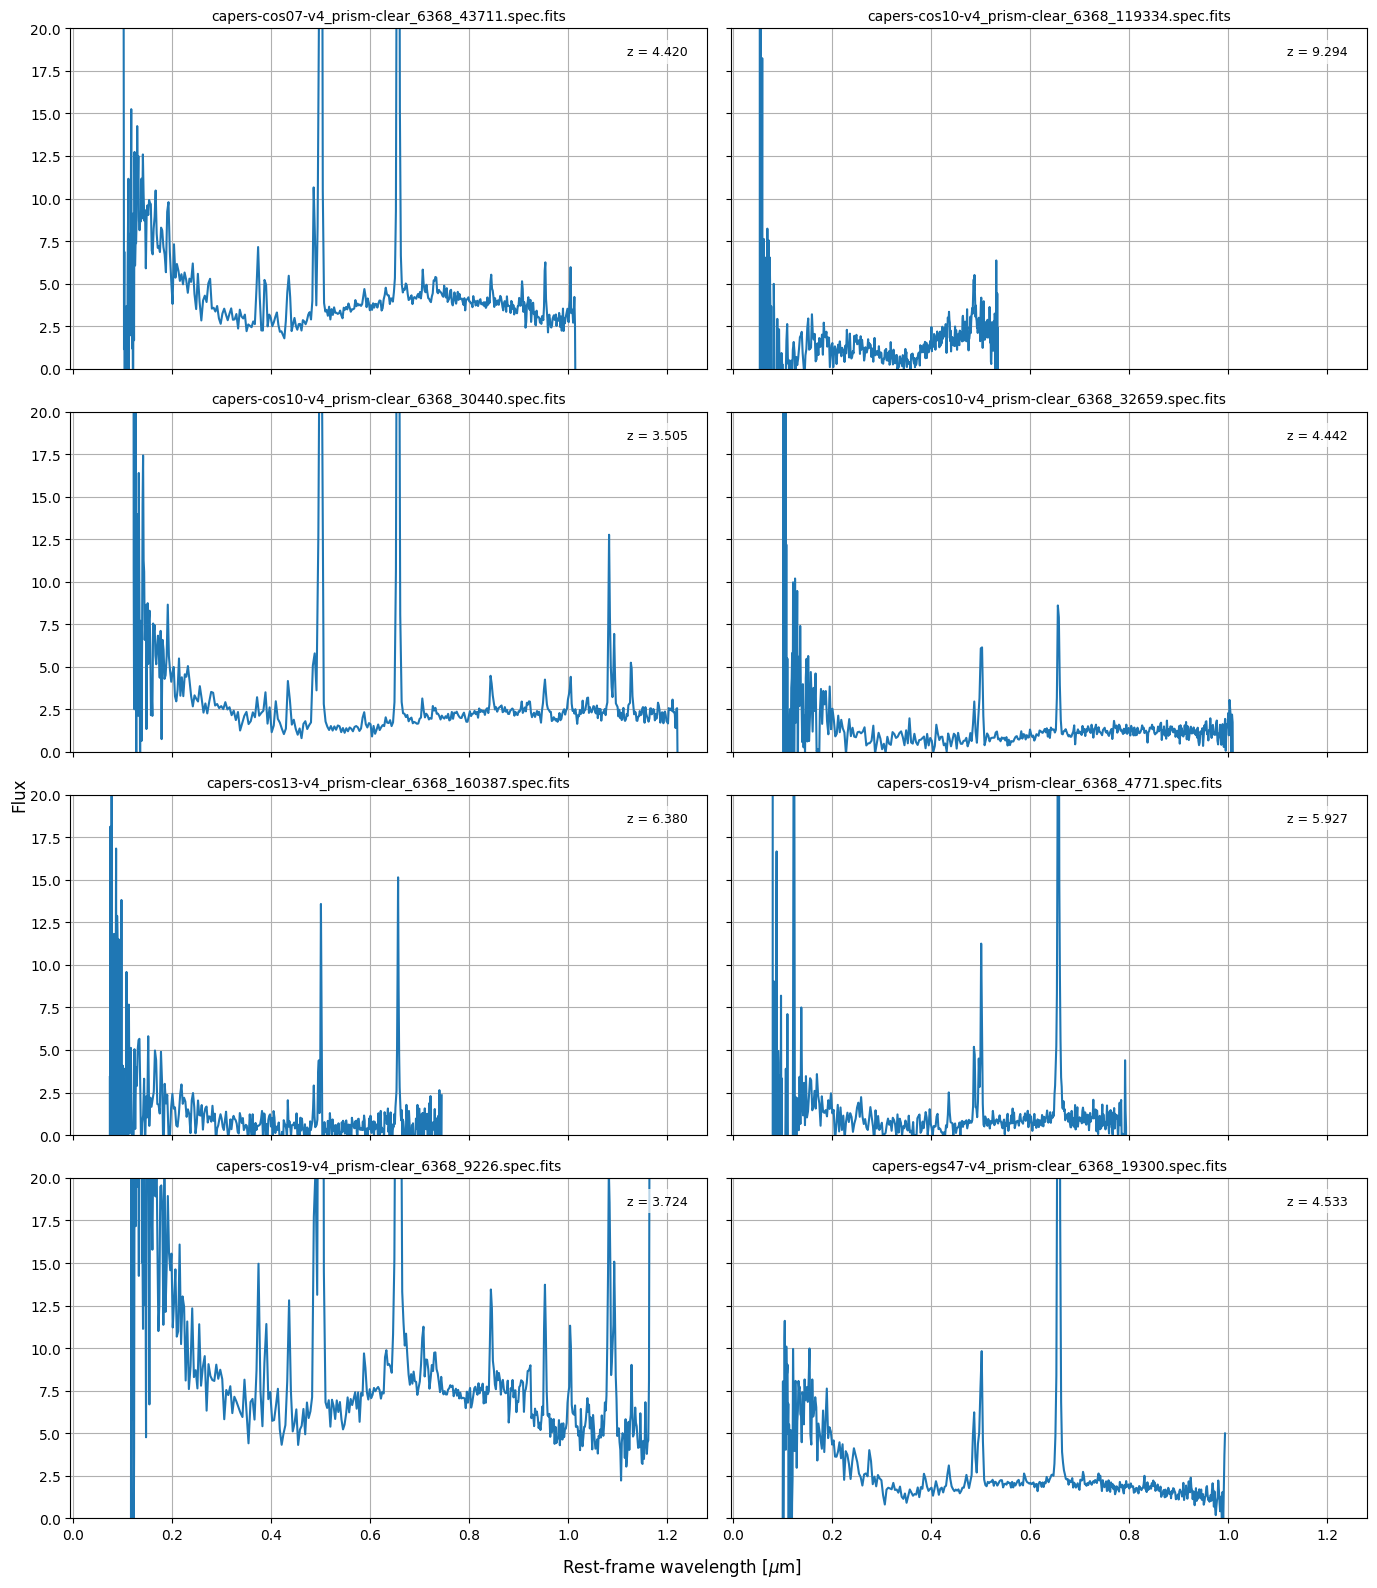

In [21]:
#example of a panel
fig = make_spectrum_panel(
    spec_info_clear,
    ylim=(0,20),
    loader_kwargs=dict(
        input_flux_unit="uJy",
        wave_unit="um",
        restframe=True,
        output_flux_scale=1e20,
    ),
    start=0
)
